In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns

In [68]:
# Set plot style simply
sns.set()

In [70]:
# Load DeFiLlama yields data
def load_data(file_path='yield_cleaned.csv'):
    """Load the DeFiLlama yields data with error handling"""
    try:
        # For newer pandas versions
        df = pd.read_csv(file_path, on_bad_lines='skip')
    except TypeError:
        # For older pandas versions
        df = pd.read_csv(file_path, error_bad_lines=False)
    
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# Preprocess the data
def preprocess_data(df):
    """Clean and prepare data for clustering"""
    df_processed = df.copy()
    
    # Convert string columns to numeric where possible
    numeric_cols = ['TVL', 'APY', 'APY Base', 'APY Reward', 'Change 1d', 'Change 7d', 
                   'Confidence', 'APY Base 7d', 'APY Net 7d', 'APY Mean 30d',
                   'Volume 1d', 'Volume 7d']
    
    # Handle missing values
    for col in numeric_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # For categorical columns, fill NaN with 'Unknown'
    categorical_cols = ['Chain', 'Project', 'Category', 'Outlook']
    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('Unknown')
    
    return df_processed


In [72]:
# Engineer risk features
def engineer_risk_features(df):
    """Create risk-related features for clustering"""
    df_risk = df.copy()
    
    # Calculate volatility
    if 'Change 1d' in df_risk.columns:
        df_risk['Volatility_1d'] = df_risk['Change 1d'].abs()
    if 'Change 7d' in df_risk.columns:
        df_risk['Volatility_7d'] = df_risk['Change 7d'].abs()
    
    # Log transform TVL
    if 'TVL' in df_risk.columns:
        df_risk['Log_TVL'] = np.log1p(df_risk['TVL'])
    
    # APY risk ratio
    if 'APY' in df_risk.columns:
        df_risk['APY_Risk'] = df_risk['APY'] / df_risk['Log_TVL'].replace(0, 0.1)
    
    # Select features for clustering - only include columns that actually exist
    risk_features = []
    for col in ['APY', 'Log_TVL', 'Volatility_1d', 'Volatility_7d', 'APY_Risk', 'Confidence']:
        if col in df_risk.columns:
            risk_features.append(col)
    
    # Add categorical features for encoding
    categorical_features = []
    for col in ['Chain', 'Project', 'Category']:
        if col in df_risk.columns:
            categorical_features.append(col)
    
    return df_risk, risk_features, categorical_features

# Create ML pipeline with fixed PCA component
def create_clustering_pipeline(df, numeric_features, categorical_features):
    """Create a machine learning pipeline for risk clustering"""
    
    # Create preprocessing for numeric features
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Create preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # FIX: Use fixed number of components instead of percentage
    # or explicitly set svd_solver to 'full'
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        # Option 1: Use a fixed number of components
        ('pca', PCA(n_components=min(10, len(numeric_features) + len(categorical_features) - 1))),
        # OR Option 2: Use percentage but with full solver
        # ('pca', PCA(n_components=0.95, svd_solver='full')),
        ('cluster', KMeans(n_clusters=3, random_state=42, n_init=10))
    ])
    
    return pipeline


In [74]:
# Risk scoring function
def fit_and_score(df, pipeline, numeric_features, categorical_features):
    """Fit the clustering model and assign risk scores with better debugging"""
    
    # Get feature matrix
    X = df[numeric_features + categorical_features]
    print(f"Feature matrix shape: {X.shape}")
    
    # Fit the pipeline
    print("\nFitting KMeans clustering pipeline...")
    pipeline.fit(X)
    
    # Get cluster labels
    df['Cluster'] = pipeline.named_steps['cluster'].labels_
    
    # Print cluster distribution
    print("\nCluster distribution:")
    print(df['Cluster'].value_counts())
    
    # Debugging: Check value ranges before calculation
    print("\nValue ranges for risk calculation:")
    print(f"APY range: {df['APY'].min()} to {df['APY'].max()}")
    print(f"Log_TVL range: {df['Log_TVL'].min()} to {df['Log_TVL'].max()}")
    
    # RESET the approach completely to be simpler and more robust
    # 1. Rank pools by APY (higher = riskier)
    df['APY_Rank'] = df['APY'].rank(pct=True)
    
    # 2. Rank pools by TVL (lower = riskier)
    df['TVL_Rank'] = 1 - df['Log_TVL'].rank(pct=True)
    
    # 3. Create a simple risk score from these rankings (0-100)
    df['Risk_Score'] = (df['APY_Rank'] * 0.6 + df['TVL_Rank'] * 0.4) * 100
    
    # 4. Add volatility if available
    if 'Volatility_7d' in df.columns and df['Volatility_7d'].notna().any():
        df['Vol_Rank'] = df['Volatility_7d'].rank(pct=True)
        df['Risk_Score'] = df['Risk_Score'] * 0.8 + df['Vol_Rank'] * 20
    
    # Debugging: Show risk score distribution
    print("\nRisk score stats:")
    print(df['Risk_Score'].describe())
    
    # 5. Create equal-sized categories (approximately)
    try:
        # Create terciles (3 equal groups)
        terciles = [0, 33.3, 66.6, 100]
        df['Risk_Category'] = pd.cut(
            df['Risk_Score'],
            bins=terciles,
            labels=['Low Risk', 'Medium Risk', 'High Risk']
        )
    except Exception as e:
        print(f"Error in categorization: {e}")
        # Fallback approach: manual categorization
        conditions = [
            (df['Risk_Score'] < 33.3),
            (df['Risk_Score'] >= 33.3) & (df['Risk_Score'] < 66.6),
            (df['Risk_Score'] >= 66.6)
        ]
        choices = ['Low Risk', 'Medium Risk', 'High Risk']
        df['Risk_Category'] = np.select(conditions, choices, default='Medium Risk')
    
    # Count pools in each risk category
    print("\nPools in each risk category:")
    risk_counts = df['Risk_Category'].value_counts()
    print(risk_counts)
    
    return df, None

In [76]:
# Simplified visualization function
def visualize_clusters(df, cluster_stats):
    """Create basic visualizations of the clustered data"""
    
    # Plot 1: APY vs TVL with clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df['Log_TVL'], df['APY'], 
        c=df['Cluster'], 
        s=50, alpha=0.7, 
        cmap='viridis'
    )
    plt.xlabel('Log(TVL)')
    plt.ylabel('APY (%)')
    plt.title('APY vs TVL by Cluster')
    plt.grid(True, alpha=0.3)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()
    
    # Plot 2: Distribution of risk scores
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Risk_Score'], bins=20, kde=True)
    plt.xlabel('Risk Score (0-100)')
    plt.title('Distribution of Risk Scores')
    plt.axvline(x=30, color='g', linestyle='--', label='Low/Medium Boundary')
    plt.axvline(x=70, color='r', linestyle='--', label='Medium/High Boundary')
    plt.legend()
    plt.show()
    
    return


In [78]:
# Main function to run the analysis
def analyze_yield_pools(file_path='yieldssmall.csv'):
    """Run the yield pool risk analysis with simplified error handling"""
    
    try:
        # Load data
        df = load_data(file_path)
        
        # Preprocess data
        df_clean = preprocess_data(df)
        
        # Engineer risk features
        df_risk, numeric_features, categorical_features = engineer_risk_features(df_clean)
        
        # Create pipeline
        pipeline = create_clustering_pipeline(df_risk, numeric_features, categorical_features)
        
        # Fit model and score
        df_scored, cluster_stats = fit_and_score(df_risk, pipeline, numeric_features, categorical_features)
        
        # Basic visualization
        visualize_clusters(df_scored, cluster_stats)
        
        # Get top pools by risk category
        top_pools = {}
        for category in ['Low Risk', 'Medium Risk', 'High Risk']:
            top_pools[category] = df_scored[df_scored['Risk_Category'] == category].sort_values('APY', ascending=False).head(5)
            print(f"\nTop 5 {category} pools by APY:")
            print(top_pools[category][['Pool', 'Project', 'Chain', 'APY', 'Risk_Score']])
        
        return df_scored, top_pools
    
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None, None


Loaded dataset with 78 rows and 28 columns
Feature matrix shape: (78, 9)

Fitting KMeans clustering pipeline...

Cluster distribution:
Cluster
2    44
1    27
0     7
Name: count, dtype: int64

Value ranges for risk calculation:
APY range: 1.06772 to 11.66143
Log_TVL range: 16.118539552419485 to 23.436675299849515

Risk score stats:
count    78.000000
mean     50.230769
std      19.583685
min       9.794872
25%      33.358974
50%      50.179487
75%      68.102564
max      90.769231
Name: Risk_Score, dtype: float64

Pools in each risk category:
Risk_Category
Medium Risk    36
High Risk      22
Low Risk       20
Name: count, dtype: int64


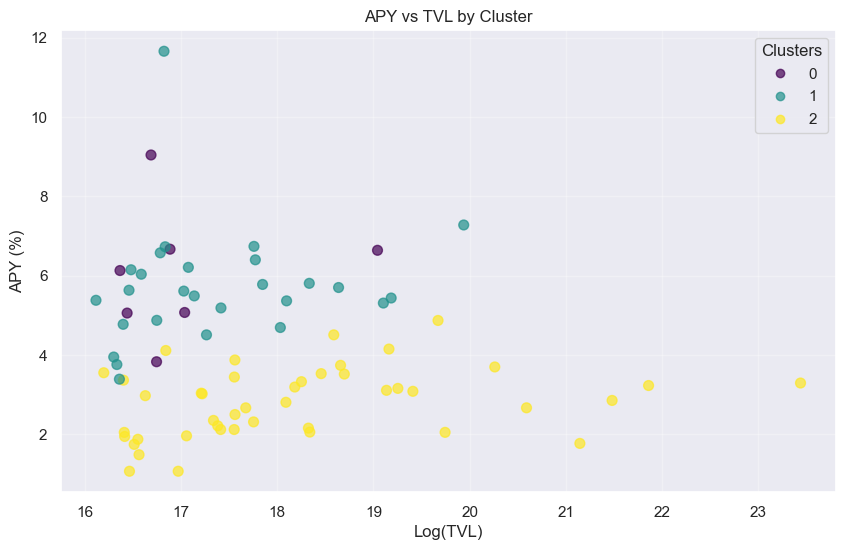

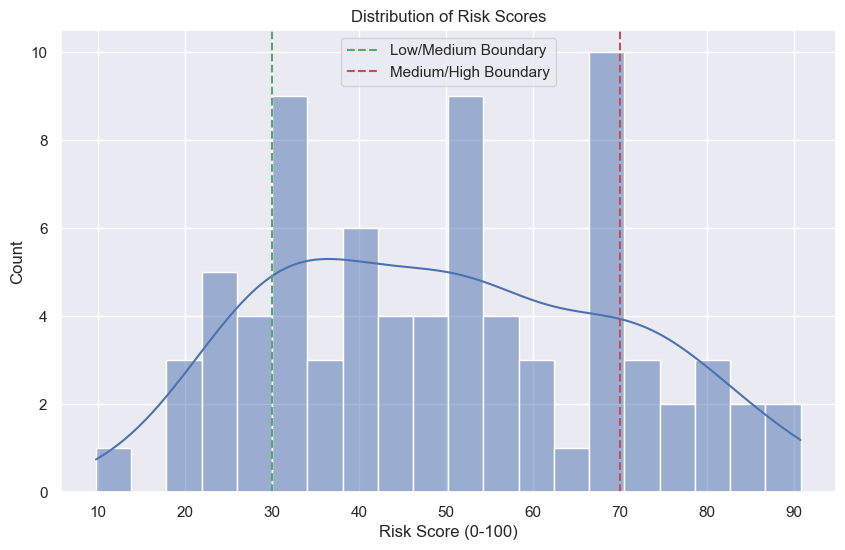


Top 5 Low Risk pools by APY:
      Pool             Project     Chain      APY  Risk_Score
17    USDC         Compound V3  Ethereum  3.73919   32.102564
5     METH       mETH Protocol  Ethereum  3.69841   29.641026
20  APXETH      Dinero (pxETH)  Ethereum  3.53000   33.282051
0    STETH                Lido  Ethereum  3.29300   32.666667
1    WBETH  Binance staked ETH  Ethereum  3.23025   27.589744

Top 5 Medium Risk pools by APY:
          Pool      Project     Chain      APY  Risk_Score
22   STEAKRUSD  Morpho Blue  Ethereum  5.80754   52.871795
29      REUSDC  Morpho Blue  Ethereum  5.77967   55.897436
18     BBQUSDC  Morpho Blue  Ethereum  5.70204   53.846154
49     SFRXUSD         Frax  Ethereum  5.61188   63.794872
11  USUALUSDC+  Morpho Blue  Ethereum  5.43704   54.153846

Top 5 High Risk pools by APY:
       Pool        Project     Chain       APY  Risk_Score
54  SFRXETH       Fraxlend  Ethereum  11.66143   80.410256
58   SMWETH    Morpho Blue      Base   9.04515   90.666667
6  

In [80]:
# Run the analysis with error handling
df_scored, top_pools = analyze_yield_pools('yield_cleaned.csv')

In [82]:
# Save the data with risk scores
df_scored.to_csv('yield_pools_with_risk_scores.csv', index=False)
print("File saved successfully!")

File saved successfully!
